In [1]:
# !pip install opencv-python matplotlib tensorflow-datasets

In [2]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import uuid

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Input, Flatten
import tensorflow as tf
import tensorflow_datasets as tfds

2024-08-31 15:01:19.432423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 15:01:19.450785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 15:01:19.456396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 15:01:19.469320: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-31 15:01:20.371592: W tensorflow/compiler/tf2

# Set GPU Growth

In [4]:
#avoid out of memory erros by setting GPU memory growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2024-08-31 15:01:21.092021: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-08-31 15:01:21.092053: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: nitro
2024-08-31 15:01:21.092061: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: nitro
2024-08-31 15:01:21.092160: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 535.183.1
2024-08-31 15:01:21.092200: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 535.183.1
2024-08-31 15:01:21.092208: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 535.183.1


In [5]:
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

## Folder structures

In [6]:
POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANC_PATH = os.path.join("data", "anchor")

In [7]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [8]:
lfw_dataset, info = tfds.load('lfw', split='train', with_info=True, as_supervised=True)

# Display dataset information
print(info)

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild: A Database for Studying Face Recognition in
    Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_dir='/home/andersonc/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=uint8),
        'label': Text(shape=(), dtype=string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
     

In [9]:
# Function to save images to a directory
def save_image(image, index, directory):
    # Convert the image tensor to a NumPy array and then to uint8
    image_np = tf.image.convert_image_dtype(image, dtype=tf.uint8).numpy()

    # Encode image in JPEG format
    image_encoded = tf.image.encode_jpeg(image_np)
    
    # Define the path to save the image
    image_path = os.path.join(directory, f'image_{index}.jpg')
    
    # Write the image to the file
    tf.io.write_file(image_path, image_encoded)

# Move all images to the negative directory
for index, (label, image) in enumerate(lfw_dataset):
    save_image(image, index, NEG_PATH)

print(f"All images have been moved to the {NEG_PATH} directory.")

All images have been moved to the data/negative directory.


2024-08-31 15:01:36.458751: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Colect Positive and Anchor Classes

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

    if cv2.waitKey(1) & 0XFF == ord('p'):
        cv2.imwrite(os.path.join(POS_PATH, f"image_{random.randint(0, 1000)}.jpg"), frame)  
    
cap.release()
cv2.destroyAllWindows()

In [11]:
#Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        (x, y, w, h) = faces[0] 
        center_x, center_y = x + w // 2, y + h // 2
        
        # Define the dimensions for the centered crop
        half_width = 125  # Half of the target width 250
        half_height = 125  # Half of the target height 250

        
        start_x = max(center_x - half_width, 0)
        start_y = max(center_y - half_height, 0)
        end_x = min(center_x + half_width, frame.shape[1])
        end_y = min(center_y + half_height, frame.shape[0])
        
        
        cropped_frame = frame[start_y:end_y, start_x:end_x]
        
        
        resized_frame = cv2.resize(cropped_frame, (250, 250))
    else:
        
        resized_frame = cv2.resize(frame, (250, 250))
    
    
    cv2.imshow('frame', resized_frame)

    if cv2.waitKey(1) & 0xFF == ord('p'):
        image_path = os.path.join(POS_PATH, f"{uuid.uuid1()}.jpg")
        cv2.imwrite(image_path, resized_frame)
        print(f"Saved frame to {image_path}")

    if cv2.waitKey(1) & 0xFF == ord('a'):
        image_path = os.path.join(ANC_PATH, f"{uuid.uuid1()}.jpg")
        cv2.imwrite(image_path, resized_frame)
        print(f"Saved frame to {image_path}")
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    

cap.release()
cv2.destroyAllWindows()

Saved frame to data/anchor/1de3a06a-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/1ed70ca0-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/1fd8a654-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/22eba742-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/245a72fc-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/27cb8e3a-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/284c46d8-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/2f8394ce-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/30be0e64-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/anchor/39c22a7c-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/positive/3a2cb752-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/positive/3a4349d6-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/positive/3a5ee664-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/positive/3a798442-67c3-11ef-80ac-dc215cb50b44.jpg
Saved frame to data/positive/3a980b56-67

# Load and process images

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH + "/*.jpg").take(3)
positive = tf.data.Dataset.list_files(POS_PATH + "/*.jpg").take(3)
negative = tf.data.Dataset.list_files(NEG_PATH + "/*.jpg").take(3)


In [15]:
dir_test = anchor.as_numpy_iterator().next().decode("utf-8")
print(dir_test)

data/anchor/c2d344c2-67be-11ef-8b57-dc215cb50b44.jpg


In [23]:
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [100, 100])
    img = img / 255.0
    return img

In [24]:
img = preprocess_image(dir_test)

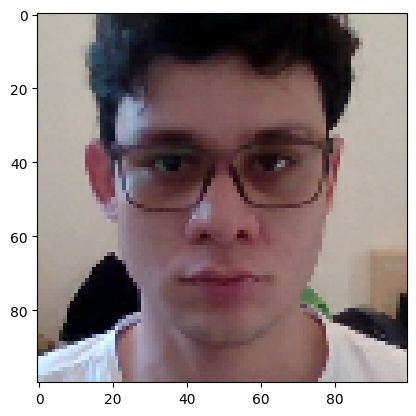

In [25]:
plt.imshow(img)

In [32]:
# create labelled dataset

class_labels = tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))
iterator_labs = class_labels.as_numpy_iterator()
iterator_labs.next()


0.0

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
dataset = tf.data.Dataset.concatenate(positives, negatives)

In [36]:
samples = dataset.as_numpy_iterator()

In [37]:
samples.next()

(b'data/anchor/1fd8a654-67c3-11ef-80ac-dc215cb50b44.jpg',
 b'data/positive/3aebd344-67c3-11ef-80ac-dc215cb50b44.jpg',
 1.0)

In [38]:
def process_twin(input_img, validatioin_img, label):
    return preprocess_image(input_img), preprocess_image(validatioin_img), label

In [40]:
res = process_twin(*samples.next())

In [44]:
#build dataloader pipeline

dataset = dataset.map(process_twin)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)

In [45]:
# Training  partitions
train_data = dataset.take(round(len(dataset)*0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [46]:
# Testing partitions
test_data = dataset.skip(round(len(dataset)*0.8))
test_data = test_data.take(round(len(dataset)*0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)
